In [17]:
import rasterio
from rasterio.plot import show
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

In [18]:
path = "data/landsat9_rgb.tif"
ds = rasterio.open(path)

In [19]:
print("CRS:", ds.crs)
print("Bounds:", ds.bounds)
print("Número de bandas:", ds.count)
print("Dimensões (linhas, colunas):", ds.height, ds.width)

CRS: EPSG:32720
Bounds: BoundingBox(left=395530.0, bottom=9021540.0, right=416130.0, top=9041630.0)
Número de bandas: 3
Dimensões (linhas, colunas): 2009 2060


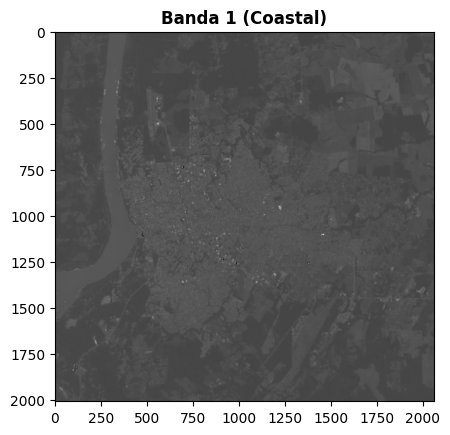

<Axes: title={'center': 'Banda 1 (Coastal)'}>

In [23]:
show(ds.read(1), cmap="gray", title="Banda 1 (Coastal)")